# Web Scraping for Reddit & Predicting Comments

In this project, we will practice two major skills. Collecting data by scraping a website and then building a binary predictor.

As we discussed in week 2, and earlier today, there are two components to starting a data science problem: the problem statement, and acquiring the data.

For this article, your problem statement will be: _What characteristics of a post on Reddit contribute most to the overall interaction (as measured by number of comments)?_

Your method for acquiring the data will be scraping the 'hot' threads as listed on the [Reddit homepage](https://www.reddit.com/). You'll acquire _AT LEAST FOUR_ pieces of information about each thread:
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

Once you've got the data, you will build a classification model that, using Natural Language Processing and any other relevant features, predicts whether or not a given Reddit post will have above or below the _median_ number of comments.

**BONUS PROBLEMS**
1. If creating a logistic regression, GridSearch Ridge and Lasso for this model and report the best hyperparameter values.
1. Scrape the actual text of the threads using Selenium (you'll learn about this in Webscraping II).
2. Write the actual article that you're pitching and turn it into a blog post that you host on your personal website.

### Scraping Thread Info from Reddit.com

#### Set up a request (using requests) to the URL below. Use BeautifulSoup to parse the page and extract all results

In [208]:
# import our necessary first packages
import pandas as pd
import pickle
import urllib
import requests
import numpy as np
import time
import datetime
import os
import matplotlib
import matplotlib.pyplot as plt
import scipy as sp


%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')



from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from ipywidgets import *
from IPython.display import display
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from time import sleep
from uuid import uuid4 as uuid  # this is a randomly generated ID
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.stem.snowball import SnowballStemmer


In [203]:

url1 = "http://www.reddit.com/r/all/"
html1 = requests.get(url1, headers={'User-agent': str(uuid())})
soup1 = BeautifulSoup(html1.text, "lxml") 

In [206]:
#print(titles)
titles = []
for title in soup1.find_all('a', class_='title may-blank outbound'):
    titles = (title.text)
print(titles)

"When it was a Nazi, Trump needed more facts. When it was a Muslim, that was the only fact he needed." | Daily Show


In [328]:
print(times)
time = []
for time in soup1.find_all('time', class_='live-timestamp'):
    times = (time['datetime'])
print(times)

2017-11-02T12:24:18+00:00


In [327]:
#print(subreddits)
subreddit = []
for subreddit in soup1.find_all('a', class_='subreddit hover may-blank'):
    subreddits = (subreddit.text)
print(subreddits)

r/LateStageCapitalism


In [329]:
#print(comments)
comments = []
for comments in soup1.find_all('a', class_='bylink comments may-blank'):
    comments = (comments.text)
print(comments)

593 comments


While this has some more verbose elements removed, we can see that there is some structure to the above:
- The thread title is within an `<a>` tag with the attribute `data-event-action="title"`.
- The time since the thread was created is within a `<time>` tag with attribute `class="live-timestamp"`.
- The subreddit is within an `<a>` tag with the attribute `class="subreddit hover may-blank"`.
- The number of comments is within an `<a>` tag with the attribute data-event-action="comments"`.

## Write 4 functions to extract these items (one function for each): title, time, subreddit, and number of comments.¶
Example
```python
def extract_title_from_result(result):
    return result.find ...
```

##### - Make sure these functions are robust and can handle cases where the data/field may not be available.
>- Remember to check if a field is empty or None for attempting to call methods on it
>- Remember to use try/except if you anticipate errors.

- **Test** the functions on the results above and simple examples

In [331]:
#Title function
def title_url(soup1):
    for title in soup1.find_all('a', class_='title may-blank outbound'):
        titles = (title.text)

In [330]:
#Time function
def time_url(soup1):
    for time in soup1.find_all('time', class_='live-timestamp'):
        times = (time['datetime'])

In [332]:
#Subreddit function
def subreddit_url(soup1):
    for subreddit in soup1.find_all('a', class_='subreddit hover may-blank'):
        subreddits = (subreddit.text)

In [333]:
def comments_url(soup1):
    for comments in soup1.find_all('a', class_='bylink comments may-blank'):
        comments = (comments.text)

Now, to scale up our scraping, we need to accumulate more results.

First, look at the source of a Reddit.com page: (https://www.reddit.com/).
Try manually changing the page by clicking the 'next' button on the bottom. Look at how the url changes.

After leaving the Reddit homepage, the URLs should look something like this:
```
https://www.reddit.com/?count=25&after=t3_787ptc
```

The URL here has two query parameters
- count is the result number that the page starts with
- after is the unique id of the last result on the _previous_ page

In order to scrape lots of pages from Reddit, we'll have to change these parameters every time we make a new request so that we're not just scraping the same page over and over again. Incrementing the count by 25 every time will be easy, but the bizarre code after `after` is a bit trickier.

To start off, let's look at a block of HTML from a Reddit page to see how we might solve this problem:
```html
<div class=" thing id-t3_788tye odd gilded link " data-author="LordSneaux" data-author-fullname="t2_j3pty" data-comments-count="1548" data-context="listing" data-domain="v.redd.it" data-fullname="t3_788tye" data-kind="video" data-num-crossposts="0" data-permalink="/r/funny/comments/788tye/not_all_heroes_wear_capes/" data-rank="25" data-score="51468" data-subreddit="funny" data-subreddit-fullname="t5_2qh33" data-timestamp="1508775581000" data-type="link" data-url="https://v.redd.it/ush0rh2tultz" data-whitelist-status="all_ads" id="thing_t3_788tye" onclick="click_thing(this)">
      <p class="parent">
      </p>
      <span class="rank">
       25
      </span>
      <div class="midcol unvoted">
       <div aria-label="upvote" class="arrow up login-required access-required" data-event-action="upvote" role="button" tabindex="0">
       </div>
       <div class="score dislikes" title="53288">
        53.3k
       </div>
       <div class="score unvoted" title="53289">
        53.3k
       </div>
       <div class="score likes" title="53290">
        53.3k
       </div>
       <div aria-label="downvote" class="arrow down login-required access-required" data-event-action="downvote" role="button" tabindex="0">
       </div>
      </div>
```

Notice that within the `div` tag there is an attribute called `id` and it is set to `"thing_t3_788tye"`. By finding the last ID on your scraped page, you can tell your _next_ request where to start (pass everything after "thing_").

For more info on this, you can take a look at the [Reddit API docs](https://github.com/reddit/reddit/wiki/JSON)

## Write one more function that finds the last `id` on the page, and stores it.

In [ ]:
#last_id1 = [last['data-fullname'] for last in html.find_all('div', attrs = {"class":"thing"})]
#print(last_id1[24])

## Now, let's put it all together.

Use the functions you wrote above to parse out the 4 fields - title, time, subreddit, and number of comments. Create a dataframe from the results with those 4 columns.

In [334]:
def reddit_scrape(post):
    try:
        post_id = post["data-fullname"]

    except:
        post_id = np.NaN #appends a null value to the data frame if nothing is returned.

    try:
        title = post.find('a', attrs={"data-event-action": 'title'}).text

    except:
        title = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        timestamp = post["data-timestamp"]

    except:
        timestamp = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        url = post["data-url"]

    except:
        url = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        subreddit = post["data-subreddit"]

    except:
        subreddit = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        author = post["data-author"]

    except:
        author = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        rank = post["data-rank"]

    except:
        rank = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        comment_count = post["data-comments-count"]

    except:
        comment_count = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        score = post["data-score"]

    except:
        score = np.NaN #appends a null value to the data frame if nothing is returned.


    try:
        crossposts = post["data-num-crossposts"]

    except:
        crossposts = np.NaN #appends a null value to the data frame if nothing is returned.


    post_data = {'scrape-time': datetime.datetime.now().timestamp(), 'title': title, 'post_id': post_id, 'timestamp': timestamp, 'url': url,
                'subreddit': subreddit, 'author': author, 'rank': rank,
                'comment_count': comment_count, 'score': score, 'crossposts': crossposts}

    return post_data

### Save your results as a CSV
You may do this regularly while scraping data as well, so that if your scraper stops of your computer crashes, you don't lose all your data.

In [ ]:
#Chris helped with the pagination on reddit pages


print("Start")#shows that the process below has started 

last_id = None

df = pd.DataFrame()
filename = ('scraped_reddit.csv')

for i in range(1000): # number of pages to scrape
    try:
        if not i%10:#This gives you an update ever ten pages so you can see how many have been processed
            print("Page: {}\n".format(i))


        scraped_data = [] #An empty list to store the scraped data in

        url = "http://www.reddit.com/r/all/?count=25&after={}".format(last_id) if last_id else "https://www.reddit.com/r/all"
        html = requests.get(url, headers={'User-agent': str(uuid())})#Changing the user agent to not receive the parsing error from reddit 
        soup = BeautifulSoup(html.text, "lxml") 

        for post in soup.find_all('div', attrs={'data-context': 'listing'}):

            data = reddit_scrape(post)

            scraped_data.append(data)
            post_id = data['post_id']
            print("title: {}, page: {}, post_id: {}, subreddit: {}, author: {}".format(data['title'], i, post_id, data['subreddit'], data['author']))


        df = df.append(scraped_data)

        last_id = post_id
#assigns the last post id that is scraped on the page as the last_id
    except:
            continue


if not os.path.isfile(filename):
    df.to_csv(filename)

else:
    df.to_csv(filename, mode='a', header=False)

## Predicting comments using Random Forests + Another Classifier

#### Load in the the data of scraped results

In [51]:
## YOUR CODE HERE
reddit_df = pd.read_csv('scraped_reddit.csv')

In [55]:
#Running EDA
reddit_df.drop_duplicates(['post_id'], inplace = True, keep='last')

In [56]:
reddit_df.post_id.value_counts()

t3_79uful    1
t3_79uizh    1
t3_79uuix    1
t3_79vdd4    1
t3_79sth0    1
t3_79tem2    1
t3_79pzpl    1
t3_79tgse    1
t3_79rkpw    1
t3_79ua6e    1
t3_79v8y7    1
t3_79o7y9    1
t3_79srhi    1
t3_79vfq0    1
t3_79tbmm    1
t3_79slps    1
t3_79sdxg    1
t3_79sduy    1
t3_79se8b    1
t3_79swla    1
t3_79vfhu    1
t3_79sps5    1
t3_79s9cd    1
t3_79ub20    1
t3_79om1w    1
t3_79v7il    1
t3_79ukfc    1
t3_79uwuw    1
t3_79u63s    1
t3_79tx0i    1
            ..
t3_79smu3    1
t3_79ol6l    1
t3_79t0rz    1
t3_79sdf4    1
t3_79skeq    1
t3_79qjiw    1
t3_79uktn    1
t3_79skwa    1
t3_79udhr    1
t3_79vs24    1
t3_79urcy    1
t3_79osz0    1
t3_79sxdh    1
t3_79vks1    1
t3_79ucm9    1
t3_79qpey    1
t3_79q243    1
t3_79qt2f    1
t3_79vrm8    1
t3_79uwn3    1
t3_79uyr4    1
t3_79tkh4    1
t3_79ui2s    1
t3_79or3d    1
t3_79vmlz    1
t3_79vog7    1
t3_79utqo    1
t3_79vaaj    1
t3_79rvdw    1
t3_79px32    1
Name: post_id, Length: 7664, dtype: int64

In [59]:
reddit_df.shape

(7664, 12)

In [58]:
reddit_df['comment_count'].quantile([.1, .25, .5, .75,.9])
#median comments is 12

0.10      1.0
0.25      4.0
0.50     12.0
0.75     37.0
0.90    112.0
Name: comment_count, dtype: float64

In [60]:
#reddit_df.sort_values(by = 'comment_count', ascending= False).head(100)

In [73]:
reddit_df.describe()

,Unnamed: 0,comment_count,crossposts,rank,score,scrape-time,timestamp,target_comments
count,7664.000000,7664.000000,7664.000000,7664.000000,7664.000000,7.664000e+03,7.664000e+03,7664.000000
mean,11.974817,65.809760,0.004567,37.893267,992.285360,1.509459e+09,1.509423e+12,0.481080
std,7.205781,436.527551,0.083039,7.345172,4014.134894,1.045037e+02,2.387309e+07,0.499675
min,0.000000,0.000000,0.000000,1.000000,1.000000,1.509459e+09,1.509372e+12,0.000000
25%,6.000000,4.000000,0.000000,32.000000,45.000000,1.509459e+09,1.509405e+12,0.000000
50%,12.000000,12.000000,0.000000,38.000000,145.000000,1.509459e+09,1.509423e+12,0.000000
75%,18.000000,37.000000,0.000000,44.000000,477.000000,1.509459e+09,1.509446e+12,1.000000
max,24.000000,28750.000000,4.000000,50.000000,77187.000000,1.509459e+09,1.509459e+12,1.000000


#### We want to predict a binary variable - whether the number of comments was low or high. Compute the median number of comments and create a new binary variable that is true when the number of comments is high (above the median)

We could also perform Linear Regression (or any regression) to predict the number of comments here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW number of comments.

While performing regression may be better, performing classification may help remove some of the noise of the extremely popular threads. We don't _have_ to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of comment numbers. 

In [105]:
reddit_df['target_comments'] = reddit_df['comment_count'] > 37
#created a new column anything over the median was marked true anything under false



In [106]:
reddit_df.target_comments = reddit_df.target_comments.astype(int)

In [136]:
reddit_df.head(100)

,Unnamed: 0,author,comment_count,crossposts,post_id,rank,score,scrape-time,subreddit,timestamp,title,url,target_comments,total_time
0,0,ajstrange1,1616,0,t3_79v2cg,1,35090,1.509459e+09,news,1509448837000,Japanese firm gives non-smokers extra six days...,http://www.independent.co.uk/news/world/asia/j...,1,-1.507939e+12
1,1,JavaReallySucks,479,0,t3_79utf5,2,11917,1.509459e+09,PoliticalHumor,1509445286000,Filthy Cintonses,https://i.imgur.com/QE5wvRg.jpg,1,-1.507936e+12
2,2,Philo1927,631,1,t3_79uqx4,3,9301,1.509459e+09,politics,1509444271000,Trump allies can't stop accidentally referring...,http://www.businessinsider.com/sean-hannity-co...,1,-1.507935e+12
3,3,cv_sepsy,1019,0,t3_79vdku,4,4544,1.509459e+09,fantasyfootball,1509452786000,Am I [24M] overreacting or is this enough reas...,/r/fantasyfootball/comments/79vdku/am_i_24m_ov...,1,-1.507943e+12
4,4,Mr_Caterpillar,129,0,t3_79uy6q,5,6718,1.509459e+09,HighQualityGifs,1509447268000,I think I'll skip the Halloween party this year,https://i.imgur.com/tNB80Ue.gifv,1,-1.507938e+12
5,5,blackstonebite,675,0,t3_79ujmt,6,13651,1.509459e+09,worldnews,1509440823000,Report: At least 200 N Koreans killed in tunne...,https://www.malaysiakini.com/news/400184#2QCk0...,1,-1.507931e+12
6,6,Draycen,160,0,t3_79ur9i,7,8346,1.509459e+09,pokemon,1509444414000,If this post gets 2048 upvotes I'll post it ag...,https://i.redd.it/7dgl2bkm35vz.png,1,-1.507935e+12
7,7,dicksypoo,1145,0,t3_79utpg,8,1645,1.509459e+09,AskReddit,1509445408000,You buy a 50L backpack and you're confronted b...,/r/AskReddit/comments/79utpg/you_buy_a_50l_bac...,1,-1.507936e+12
8,8,Pirate_Redbeard,97,0,t3_79ueew,9,8690,1.509459e+09,freefolk,1509438221000,Dragon Ass,https://i.imgur.com/POrTFea.jpg,1,-1.507929e+12
9,9,swiftmg,120,0,t3_79uyiz,10,4228,1.509459e+09,pics,1509447427000,This dude's Patrick Bateman.,https://imgur.com/b86IJJQ,1,-1.507938e+12


In [108]:
reddit_df['total_time'] = reddit_df['scrape-time'] - reddit_df['timestamp']

In [109]:
X1 = reddit_df[['score', "total_time", 'rank']]
y1 = reddit_df[['target_comments']]

In [110]:
# create training and testing vars
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2)
print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

(6131, 3) (6131, 1)
(1533, 3) (1533, 1)


In [111]:
clf = LogisticRegression(penalty='l2')
clf.fit(X1_train,y1_train)

y1_pred_train = clf.predict(X1_train)
y1_pred_test = clf.predict(X1_test)

 #checking the classification accuracy
print(accuracy_score(y1_train,y1_pred_train))

print(accuracy_score(y1_test,y1_pred_test))

0.748980590442
0.755381604697


/Users/ksantana/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Thought experiment: What is the baseline accuracy for this model?

In [ ]:
#accuracy was 75%

#### Create a Random Forest model to predict High/Low number of comments using Sklearn. Start by ONLY using the subreddit as a feature. 

In [132]:
X2 = pd.get_dummies(reddit_df['subreddit'])

In [151]:
X2.columns

Index(['2007scape', '2healthbars', '2meirl42meirl4meirl', '2meirl4meirl',
       '30ROCK', '3DS', '3Dprinting', '3amjokes', '40kLore', '49ers',
       ...
       'xkcd', 'xxfitness', 'yesyesyesno', 'yesyesyesyesno', 'youdontsurf',
       'youseeingthisshit', 'youtubehaiku', 'yugioh', 'zelda', 'zootopia'],
      dtype='object', length=1872)

In [153]:
X2 = X2.drop(['The_Donald'],axis = 1)

In [175]:
y2 = reddit_df['target_comments']

In [178]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state=42)

rf = RandomForestClassifier(n_estimators=200)
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'log2', 10], 'max_depth': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [184]:
print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)

(5748, 1872) (5748, 1)
(1916, 1872) (1916, 1)


In [179]:
clf_grid.score(X_train, y_train)

0.74913013221990254

In [181]:
clf_grid.score(X_test, y_test)

0.75365344467640916

In [168]:
clf_grid.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [182]:
clf_grid.best_score_

0.74913013221990254

In [ ]:
clf_grid.

#### Create a few new variables in your dataframe to represent interesting features of a thread title.
- For example, create a feature that represents whether 'cat' is in the title or whether 'funny' is in the title. 
- Then build a new Random Forest with these features. Do they add any value?
- After creating these variables, use count-vectorizer to create features based on the words in the thread titles.
- Build a new random forest model with subreddit and these new features included.

In [254]:
X3 = reddit_df['title']
y3 = reddit_df[['target_comments']]

In [216]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state=42)

In [217]:
X3.shape

(7664,)

In [218]:
vect = CountVectorizer()
X3_train_dtm = vect.fit_transform(X_train)
X3_test_dtm = vect.transform(X_test)

In [219]:
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [220]:
X3_train_dtm.shape

(1872, 1872)

In [221]:
print(vect.get_feature_names()[-50:])

['wigglebutts', 'wiiu', 'wikileaks', 'wildhockey', 'windows10', 'winstupidprizes', 'wisconsin', 'witcher', 'woahdude', 'wolves', 'wonderwoman', 'woodworking', 'woof_irl', 'wordavalanches', 'worldbuilding', 'worldnews', 'worldoftanks', 'worldofwarships', 'worldpolitics', 'wot', 'wow', 'wrestlewiththeplot', 'writing', 'writingprompts', 'wtf', 'wtfgaragesale', 'wtfstockphotos', 'wwe', 'wwegames', 'wwii', 'xbox', 'xboxone', 'xenoblade_chronicles', 'xfiles', 'xkcd', 'xtrill', 'xwingtmg', 'xxfitness', 'yesyesyesno', 'yesyesyesyesno', 'youdontsurf', 'youniqueamua', 'youseeingthisshit', 'youtubehaiku', 'yovannaventura', 'yugioh', 'zelda', 'zettairyouiki', 'zoomies', 'zootopia']


In [229]:
vect = CountVectorizer()

# create document-term matrices
X3_train_dtm = vect.fit_transform(X3_train)
X3_test_dtm = vect.transform(X3_test)

# using Naive Bayes to predict title to comments
nb = MultinomialNB()
nb.fit(X3_train_dtm, y3_train)
y3_pred_class = nb.predict(X3_test_dtm)

# calculate accuracy
print(metrics.accuracy_score(y3_test, y3_pred_class))

0.732254697286


/Users/ksantana/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


#### Use cross-validation in scikit-learn to evaluate the model above. 
- Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate. 

#### Use Count Vectorizer from scikit-learn to create features from the thread titles. 
- Examine using count or binary features in the model
- Re-evaluate your models using these. Does this improve the model performance? 
- What text features are the most valuable? 

In [305]:
tvec = TfidfVectorizer(stop_words='english', max_features=1000, ngram_range=(1,3))
tvec.fit(X3_train, y3_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [356]:
X3_train

4745                                         Takeoff: ...
3737                         My Duck is resting on carpet
2646                      What are these, tacos for ants?
6752    Trump: adviser he once called "excellent" was ...
3565    [FIND] RICK AND MORTY HAT FOR YOU TO FLEX YOUR...
6321    [Weiss] Aron Baynes asked for the difference b...
1380               Well-designed all purpose Recon Helmet
414                     MRW I'm accused of sexual assault
1230                   Specs for the upcoming Razer Phone
1894                                How to Counter Varian
4913                                                Milky
2224                    Asshole parking: cyclist edition.
2796    Joseph Parker would accept a 'respectable' off...
6030    More than 1 million left in the dark after sto...
7551    Antifa protesting Mike Cernovich at Columbia U...
7451    Correction! Paul Manafort, *Who Worked for Pod...
1188         I've been tracking my net worth for 8 years.
3697    Me and

In [341]:
tvec_df  = pd.DataFrame(tvec.transform(X3_train).todense(), columns=tvec.get_feature_names()) 
tvec_df.index = X3_train.index

In [342]:
test_tvec_df  = pd.DataFrame(tvec.transform(X3_test).todense(), columns=tvec.get_feature_names())
test_tvec_df.index = X3_test.index

In [323]:
X3_test.join(test_tvec_df)

5530                                     Jaja, Pixelhansa
3908    Clarkson says LaMelo took him for $200 dollars...
5736    Which champion is the closest to being perfect...
2422    That feeling when you know you're creating a m...
6404                                      Elizabeth Olsen
4280    Conservative opposition shuts down federal fun...
3655                                              EgoFall
2955           My friend wonders why he doesn't have a GF
7407    Mark Simone: Hillary says it’s crazy that Dona...
3873                   [OC] [CC] [NEWBIE] Adorable Corgi!
7684    Solid article on Goolag, "Google is primarily ...
4054    Foundation for Economic Education: The Biggest...
132                                         Any help here
4596                                 Manchu vs. Ming 1456
3955                                     WORDY BOI SLAYIN
3212                      Does what ever a spidre nma can
457     [UPDATE] I'm in a casual sex relationship with...
836     Narcis

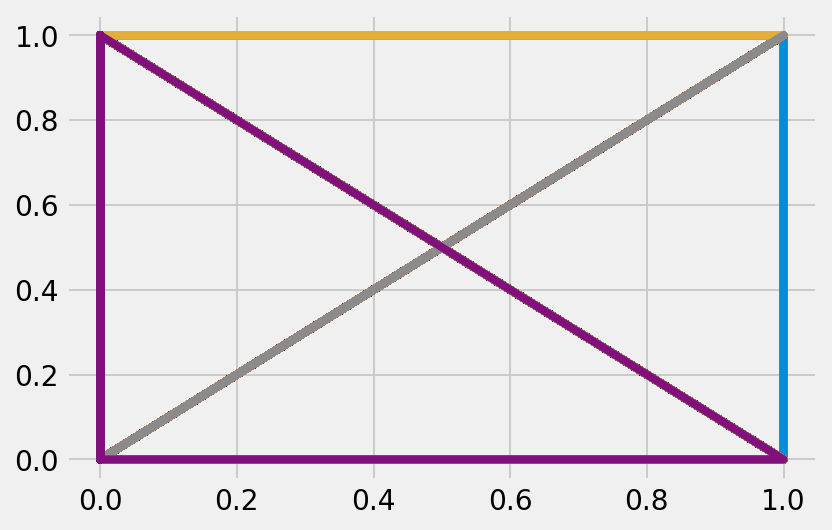

In [344]:
test_tvec_df

,000,10,10 30,10 31,100,11,12,126,13,14,...,yeah,year,year old,years,years ago,years old,yes,yesterday,york,young
5530,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3908,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
5736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2422,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
6404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
4280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3655,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2955,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
7407,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [335]:
tvec_df

,000,10,10 30,10 31,100,11,12,126,13,14,...,yeah,year,year old,years,years ago,years old,yes,yesterday,york,young
4745,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
3737,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
2646,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
6752,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.323347
3565,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
6321,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1380,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
414,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1230,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000
1894,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000


In [336]:
#Reran the equation using Logistical regression and the tfid vectorization
clf = LogisticRegression(penalty='l2')
clf.fit(tvec_df,y3_train)

y4_pred_train = clf.predict(tvec_df)
y4_pred_test = clf.predict(test_tvec_df)

 #checking the classification accuracy
print(accuracy_score(y3_train,y4_pred_train))

print(accuracy_score(y3_test,y4_pred_test))

0.768267223382
0.750521920668


/Users/ksantana/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [357]:
y4_train = y3_train
y4_test = y3_test

In [359]:
y4_train = np.squeeze(y4_train)
y4_test = np.squeeze(y4_test)

In [360]:
y4_train.shape

(5748,)

In [361]:
rf = RandomForestClassifier(n_estimators=200)
parameters = {'max_features':['sqrt', 'log2', 10],
              'max_depth':[5, 7, 9]}

clf_grid = GridSearchCV(rf, parameters, n_jobs=-1)
clf_grid.fit(tvec_df, y4_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': ['sqrt', 'log2', 10], 'max_depth': [5, 7, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [348]:
tvec_df.shape

(5748, 1000)

In [362]:
clf_grid.score(tvec_df, y4_train)

0.75086986778009746

In [363]:
clf_grid.score(test_tvec_df, y4_test)

0.75521920668058451

# Executive Summary
---
Put your executive summary in a Markdown cell below.

Reddit Engagement
Executive Summary
Kyle Santana
11/03/2017

This report provides an analysis and evaluation of the best predictor to a high comment rate on Reddit. Reddit.com is a website that is primarily organized by communities called sub-reddits, where users can post comments to. 

We investigated using logistic regression, gridsearch, and random forest models with sub-reddits as a variable.  Our highest model was gridsearch with an accuracy score of 76%. 

We would like to explore the data further into sub-reddits.  Since sub-reddits can have very different cultures. We would aim to classify comments by sub-reddit via sentiment analysis and group them based on comment similarity.

### BONUS
Refer to the README for the bonus parts

In [ ]:
## YOUR CODE HERE